In [23]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Introduction

###### Lyft Bay wheels is trying to increase profits through attracting more customers, and has provided this dataset with the expectation of an analysis being conducted and concrete recommendations being made from the data. The dataset contains data from the San Francisco bay area from 2013 to 2018 and includes over 1.9 million trips occurring between 474 stations. After analyzing the dataset I have the following recommendations:
###### 1.) To partner with local organizations to increase traffic at less popular stations such as San Pedro St. at Hedding St. and San Pablo Park. Partnering with community organizations to host events such as community bike rides, or festivals to encourage visitors to the area who would be more willing to purchase time on the Bay Wheel bikes. 
###### 2.) Focus on attracting new subscribers to the world of Bay Wheels by partnering with nearby facilities, shops, or restaurants through applications like Groupon. Offer a group discount for bike rental and lunch, or another experience with friends or family. One example could be partnering with a tennis coach to give discounts on lessons at the Missions Bay tennis courts, an underutilized location where no customers are subscribed.

###### After some close analysis I have discovered that the top 5 most popular commuter trips are:

###### 1.) 2nd at Townsend to Harry Bridges Plaza (Ferry Building)

###### 2.) Embarcadero at Sansome Steuart at Market

###### 3.) Embarcadero at Folsom San Francisco Caltrain (Townsend at 4th)

###### 4.) Harry Bridges Plaza (Ferry Building) 2nd at Townsend

###### 5.) San Francisco Caltrain (Townsend at 4th) Harry Bridges Plaza (Ferry Building)

In [100]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT * FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` WHERE (TIME(start_date) > TIME(7, 0, 0) AND TIME(start_date) < TIME(9, 0, 0)) OR (TIME(start_date) > TIME(16, 0, 0) AND TIME(start_date) < TIME(19, 0, 0)) AND duration_sec < 900 AND duration_sec > 300 AND (EXTRACT(DAYOFWEEK FROM start_date) NOT IN (1, 7)) AND start_station_id != end_station_id' > result.csv
    


Waiting on bqjob_r267031b1511b1de1_0000017a18431d4e_1 ... (9s) Current status: DONE   


## EDA 

#### Question 1: 
###### What defines a commuter trip?
#### Answer:
###### A commuter trip is one that takes place either during the morning commute hours (7am to 9am) or the afternoon commute hours (4pm to 7pm). This was chosen due to the [Tom Tom traffic Index](https://www.tomtom.com/en_gb/traffic-index/san-francisco-traffic/), which ranks the traffic and commute hours in the bay area. These trips will take place during the weekdays, when the majority of people work. Additionally, the trips will have to be longer than 5 minutes, and shorter than 19 minutes based on this [study](https://www.google.com/search?q=what+is+the+average+commute+length+on+bike&rlz=1C1GGRV_enUS751US751&oq=what+is+the+average+commute+length+on+bike&aqs=chrome..69i57.4477j0j9&sourceid=chrome&ie=UTF-8). Trips that start and end at the same station will be excluded from the table.

#### SQL Query:

In [101]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT * FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` WHERE (TIME(start_date) > TIME(7, 0, 0) AND TIME(start_date) < TIME(9, 0, 0)) OR (TIME(start_date) > TIME(16, 0, 0) AND TIME(start_date) < TIME(19, 0, 0)) AND duration_sec < 900 AND (EXTRACT(DAYOFWEEK FROM start_date) NOT IN (7, 6)) AND start_station_id != end_station_id' > Commuter_Table.csv

Waiting on bqjob_r4c04537e78d6510_0000017a18434fc2_1 ... (0s) Current status: DONE   


#### Question 2: 
###### What factors will influence a consumer's decision to rent a bike?
#### Answer:
###### The main factor seems to be geographical location, as all of the popular stations are near major commuter hubs such as Caltrain, BART stations, or the Ferry Building. This means that these stations receive a tremendous amount of foot traffic during the weekdays, but not nearly as much during the weekends. This information is beneficial to finding areas of improvement. 


#### SQL Query 1:

In [102]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT c.start_station_name, SUM(CASE WHEN s.num_bikes_available = 0 THEN 1 ELSE 0 END) AS num_times_with_no_bikes FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_status` s JOIN `strange-radius-315021.section_99.Commuter_Table` c ON c.start_station_id = s.station_id GROUP BY c.start_station_name ORDER BY num_times_with_no_bikes DESC' > q2_1.csv


Waiting on bqjob_r7102783e5fb829ac_0000017a18435768_1 ... (0s) Current status: DONE   


#### SQL Query 2:

In [103]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT c.start_station_name, COUNT(c.trip_id) AS trips FROM `strange-radius-315021.section_99.Commuter_table` c GROUP BY c.start_station_name ORDER BY trips DESC' >q2_2.csv

#### Question 3: 
###### What impact do subscriptions have on commuter trips?
#### Answer:
###### Most commuters seem to be subscribers as proven by the table, with over 618,000 commuters being subscribers and 38,000 not being subscribed to the service over the entire 4 year period. This means that Subscribers make up a majority of the commuter trips indicating that it may be easier to increase profits by focusing on the non-commuter customers rather than the commuters. 



#### SQL Query:

In [104]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT c.subscriber_type, EXTRACT(YEAR FROM c.start_date) AS Year, COUNT(trip_id) AS trips FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_status` s JOIN `strange-radius-315021.section_99.Commuter_Table` c ON c.start_station_id = s.station_id GROUP BY Year, c.subscriber_type ORDER BY Year ASC' >q3.csv

Waiting on bqjob_rcbec56f689e7117_0000017a1843674f_1 ... (1s) Current status: DONE   


### A Deeper Dive:
#### Question 3.1:
######  How does general customer growth affect subscriber growth?
#### Answer:
###### The visualization below reveals the growth trends of both the subscriber and non-subscriber groups. While the number of subscribers seems to vary there is a general upward trend, disregarding 2016 when the total amount of customers fell significantly. 


In [105]:
df = pd.read_csv('q3.csv')
df.head()

,subscriber_type,Year,trips
0,Subscriber,2013,25614
1,Customer,2013,2333
2,Subscriber,2014,102641
3,Customer,2014,4606
4,Subscriber,2015,116103


Text(27.680258333333327, 0.5, 'trips')

<Figure size 1008x432 with 0 Axes>

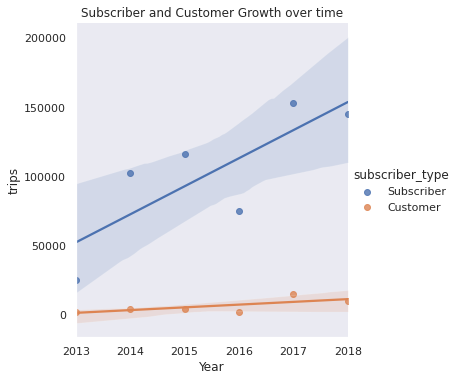

In [106]:
sns.set(color_codes=True)
sns.set_style('dark')
plt.figure(figsize=(14,6))
sns.lmplot(data=df, x='Year', y='trips', hue='subscriber_type')
plt.title('Subscriber and Customer Growth over time')
plt.xlabel("Year")
plt.ylabel("trips")



In [107]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT c.subscriber_type, EXTRACT(MONTH FROM c.start_date) AS Month, COUNT(trip_id) AS trips FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_status` s JOIN `strange-radius-315021.section_99.Commuter_Table` c ON c.start_station_id = s.station_id WHERE EXTRACT(YEAR FROM c.start_date) = 2016 GROUP BY Month, c.subscriber_type ORDER BY Month ASC' > 2016months.csv


Waiting on bqjob_r727a235a0ae4b4cd_0000017a18437962_1 ... (0s) Current status: DONE   


In [108]:
df_months = pd.read_csv('2016months.csv')
df_months.head()

,subscriber_type,Month,trips
0,Subscriber,1,7217
1,Customer,1,189
2,Subscriber,2,8546
3,Customer,2,257
4,Subscriber,3,9597


Text(25.647341666666676, 0.5, 'trips')

<Figure size 1008x432 with 0 Axes>

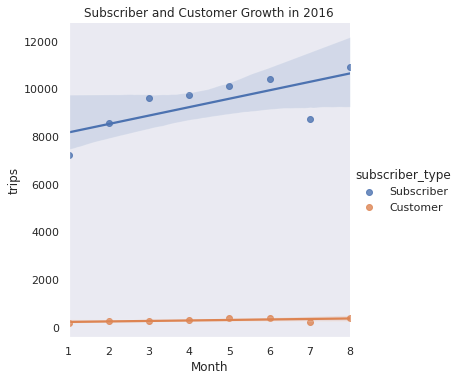

In [109]:
sns.set(color_codes=True)
sns.set_style('dark')
plt.figure(figsize=(14,6))
sns.lmplot(data=df_months, x='Month', y='trips', hue='subscriber_type')
plt.title('Subscriber and Customer Growth in 2016')
plt.xlabel("Month")
plt.ylabel("trips")

#### Analysis:
###### The visualization above showing the trend over the first 8 months of 2016 reveals that although there was growth in subscriber count per month, the non-subscriber growth flattened. This stall was due to supplier issues and [Ford donating 50 million USD to the bike-share program](https://www.kqed.org/news/11079980/the-bay-areas-expanded-bike-share-system-brought-to-you-by-ford). Although the trend proved to be interesting at first glance, after digging deeper it was revealed to be statistical noise. 

#### Question 4: 
######  Is there a difference between the number of commuters in the morning and afternoon?
#### Answer:
###### The most popular morning and afternoon trips seem to mirror each other, however, it appears that more people are traveling in the afternoon commute hours compared to the morning ones, indicating that there could potentially be more morning commuters. 



In [110]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT m.start_station_name AS start_station, m.end_station_name AS end_station, COUNT(m.trip_id) AS trips FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_status` s JOIN `strange-radius-315021.section_99.afternoon_commute` m ON m.start_station_id = s.station_id GROUP BY m.start_station_name, end_station ORDER BY trips DESC' > Morning_Commuter_Table.csv


Waiting on bqjob_r15e56247e22f1b43_0000017a1843876b_1 ... (1s) Current status: DONE   


In [111]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT m.start_station_name AS morning_start, m.end_station_name AS morning_end, COUNT(m.trip_id) AS morning_trips FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_status` s JOIN `strange-radius-315021.section_99.morning_commute` m ON m.start_station_id = s.station_id GROUP BY m.start_station_name, morning_end ORDER BY morning_trips DESC'> Afternoon_Commuter_Table.csv


Waiting on bqjob_r15263c12f6dcabcb_0000017a184396b1_1 ... (1s) Current status: DONE   


#### Question 5: 
######  Which months are the least popular for bike-sharing?
#### Answer:
###### May, June, July are the three least popular months for bike-sharing, with May and June having significantly less than July (~86,000 and 94,000 respectively).


In [112]:
! bq query --use_legacy_sql=FALSE --format=csv 'SELECT EXTRACT(MONTH FROM start_date) AS Month, COUNT(trip_id) AS trips FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` GROUP BY Month ORDER BY trips ASC'> monthly_trips.csv

Waiting on bqjob_r4d9df04730aec83b_0000017a1843a62c_1 ... (0s) Current status: DONE   


### A Deeper Dive:
#### Question 5.1:
######  What days within May and June are the least popular?
#### Answer:
###### Days 1 and 7 (Sunday and Saturday) are the least popular days by a significant amount, meaning that there is an opportunity to offer incentives to increase ridership on these days. Intuitively this discovery makes sense as Saturday and Sunday are not workdays, meaning that the commuters do not need to use the bikes to get to work at a faster pace. This could also lead to the assumption that weekend customers such as families and tourists are not incentivized to use bikes as a method of transportation.  

In [113]:
%%bigquery weekdays_df

SELECT 
    EXTRACT(DayofWeek FROM start_date) AS DayofWeek,
    COUNT(trip_id) AS trips
    FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips`
WHERE EXTRACT(MONTH FROM start_date) in (5, 6) 
GROUP BY DayofWeek
ORDER BY trips ASC

Downloading: 100%|██████████| 7/7 [00:01<00:00,  4.87rows/s]


In [114]:
weekdays_df.head()

,DayofWeek,trips
0,1,9389
1,7,10160
2,6,30879
3,2,30939
4,4,31717


Text(0, 0.5, 'Trips')

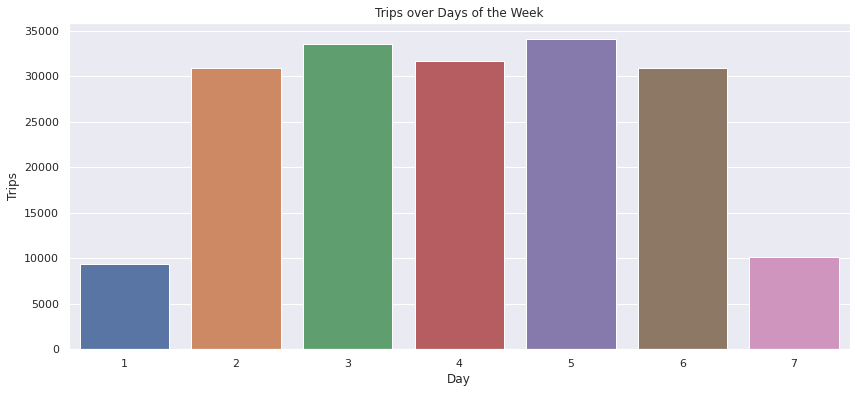

In [115]:
sns.set(color_codes=True)
sns.set_style('darkgrid')
plt.figure(figsize=(14,6))
sns.barplot(data=weekdays_df, x='DayofWeek', y='trips')
plt.title('Trips over Days of the Week')
plt.xlabel("Day")
plt.ylabel("Trips")

#### Question 6: 
######  Which stations are least popular, where are they located?
#### Answer:
###### The least popular active stations are: San Pedro St. at Hedding St.

#### SQL Query 2:

In [116]:
%%bigquery least_popular_df

SELECT i.name, SUM(
    CASE
        WHEN t.c_subscription_type = 'Subscriber' THEN 1
        ELSE 0
    END) AS Num_subs
    , COUNT(trip_id) AS trips
FROM `bigquery-public-data.san_francisco_bikeshare.bikeshare_trips` t
JOIN `bigquery-public-data.san_francisco_bikeshare.bikeshare_station_info` i
ON t.start_station_id = i.station_id
GROUP BY i.name
ORDER BY trips ASC


Downloading: 100%|██████████| 290/290 [00:01<00:00, 182.56rows/s]


### A Deeper Dive:
#### Question 7.1: 
######  Who are getting bikes from the least rented stations?
#### Answer:
###### From stations like Oak St. and San Pedro St. the customers are almost entirely subscribers. Other stations like Berry St. and King St. have no subscriptions. The lack of subscribers seems to be correlated with the unpopularity of certain stations.   

## Summary

###### In summation, I recommend Lyft introduce incentives such as: participating in community events, partnering with businesses at nearby stations, and working with tourists and families to entice them into renting the Baywheels Bikes. These recommendations are derived from data revealing that Saturday and Sunday are the least popular days of the week to rent, and non-subscriber customer growth seems to correlate with subscriber growth (and increased users). 